# Introdução a Séries Temporais

Tutorial for improve skills: 'Séries Temporais com python/pandas/statsmodels - Parte 01' (ORMaster) by Marcus Mariano

**For more information about Marcus Mariano: [Web site](https://marcusmariano.github.io/mmariano/)**  

**Séries Temporais com python/pandas/statsmodels - Parte 01 [ORMaster.](https://www.youtube.com/playlist?list=PL5fQ3JoS0SZscDaHgXahtx632NMnq5RR-)** 

**ronaldolagepessoa: [GitHub.](https://github.com/ronaldolagepessoa/timeseries)**

## Load packages

In [2]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Set parameters

In [1]:
N_THREADS = 6 # threads cnt for lgbm and linear models
N_FOLDS = 10 # folds cnt for AutoML
N_JOBS = -1 # -1 means using all processors
SEED = 0 # fixed random state for various reasons
TEST_SIZE = 0.3 # Test size for metric check
VERBOSE = 1
EPOCHS = 50
TIMEOUT = 600 # Time in seconds for automl run, 600 seconds = 10 minutes
RAM = 16 #  Number of RAM limit
CPU_LIMIT = 16 # Number of CPU limit
TARGET_NAME = 'CHURN'

# Modelo Auto-regressivo de Médias Móveis (ARMA)

O modelo ARMA é a junção dos modelos $AR(p)$ e $MA(q)$:

* $AR(p)$: tenta explicar o efeito de momentum da série.
* $MA(q)$: tenta capturar o efeito do ruído na série. Esse efeito pode ser interpretado como eventos inesperados que afetam a observação.

O modelo criado é representado pela equação:

${\displaystyle X_{t}=c+\varepsilon _{t}+\sum _{i=1}^{p}\beta _{i}X_{t-i}+\sum _{i=1}^{q}\theta _{i}\varepsilon _{t-i}.}$

A descoberta dos valores apropriados de ${\displaystyle p}$ e ${\displaystyle q}$ no modelo $ARMA({\displaystyle p,q})$ pode ser facilitada ao mapear as funções de autocorrelação parcial para um valor estimado de ${\displaystyle p}$ e, da mesma forma, usar as funções de autocorrelação para um valor estimado de ${\displaystyle q}$. Mais informações podem ser obtidas considerando as mesmas funções para os resíduos de um modelo ajustado com uma seleção inicial de ${\displaystyle p}$ e ${\displaystyle q}$.

Para testar o uso do modelo $ARMA(p, q)$ trabalharemos com os dados climáticos contidos no arquivo ```clima_india```.




In [4]:
Path = ""

data = pd.read_csv(Path+"data/clima_india.csv")
print(data.shape)
data.head()

(1462, 5)


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [8]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [16]:
data["meanpressure"].unique().sum()

635005.6106123975

4


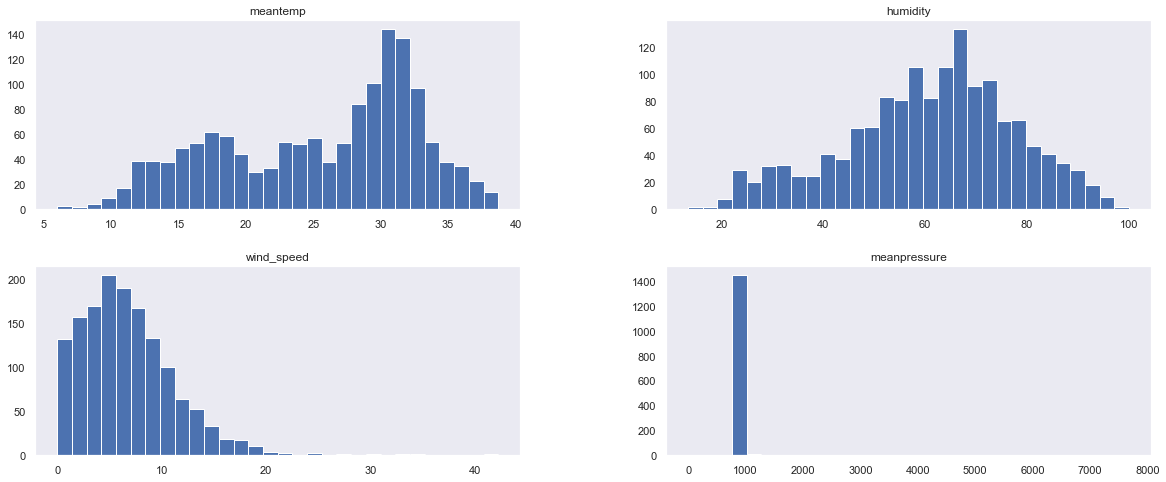

In [14]:
# Select numeric columns
cols_num = [col for col in data.select_dtypes(include="number").columns if col not in ['ID', TARGET_NAME]]
print(len(cols_num))
cols_num


data[cols_num].hist(grid=False,
                    figsize=(20, 8),
                    bins=30);

In [17]:
train = data.copy()

In [18]:

train.date = pd.to_datetime(data.date)
train.set_index('date', inplace=True)
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


Criaremos o modelo para previsão da velocidade do vento do dia, disposta na coluna ```wind_speed```. Abaixo, tempos a visualização da séries temporal.

<AxesSubplot:xlabel='date'>

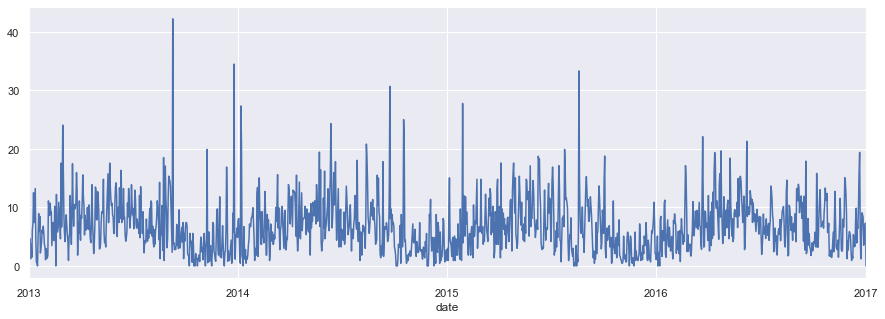

In [19]:
train.wind_speed.plot(figsize=(15, 5))

Criaremos um modelo ARMA(2, 2) utilizando a classe ```ARMA``` presente no subpacote ```from statsmodels.tsa.arima_model```. O classe recebe como parâmetro a ```Series``` contende a séres temporal, a frequência ```freq``` e a ordem ```order=(p, q)```.

In [20]:
from statsmodels.tsa.arima_model import ARMA

arma_2_2 = ARMA(train["wind_speed"], freq='D', order=(2, 2)).fit()
(arma_2_2.resid ** 2).mean()

16.181779406173657

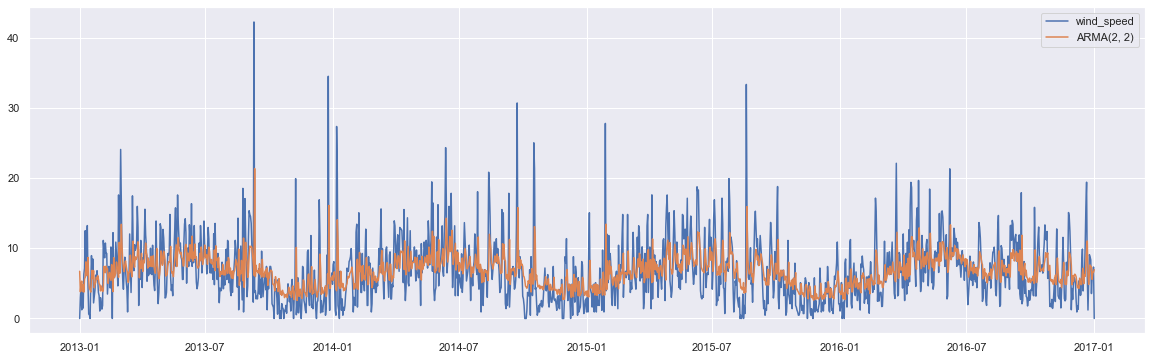

In [22]:
plt.figure(figsize=(20, 6))
plt.plot(train["wind_speed"])
plt.plot(arma_2_2.predict())
plt.legend(['wind_speed', 'ARMA(2, 2)'])

Faremos a validação _train/test_ considerando o tamanho $n$ do conjunto de treinamento como sendo 2/3 do conjunto original.

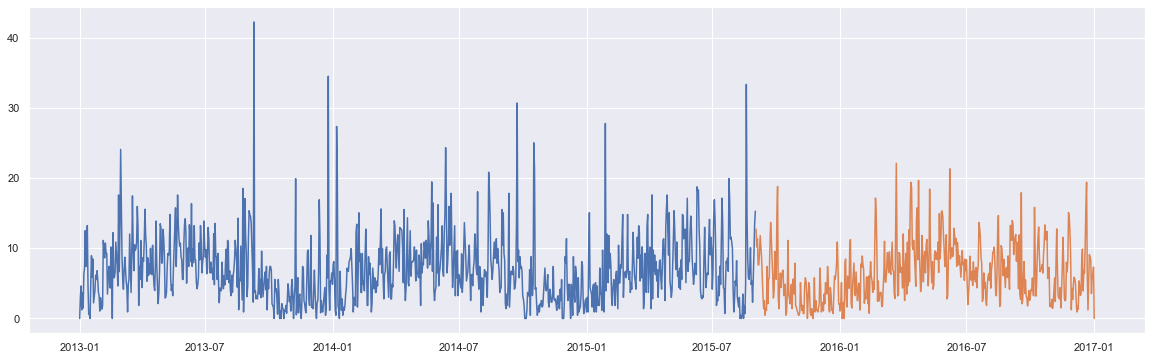

In [25]:
size = int(len(train.wind_speed) * 2/3)
X_train = train.wind_speed[:size]
X_valid = train.wind_speed[size:]

plt.figure(figsize=(20, 6))
plt.plot(X_train)
plt.plot(X_valid)

Criaremos o modelo ARMA(2, 2) a partir do conjunto ```train_set``` e acessaremos os parâmetros do modelo através do atributo ```params```.

In [26]:
arma_train = ARMA(X_train, freq='D', order=(2, 2)).fit()
arma_train.params

const               6.912805
ar.L1.wind_speed    1.212281
ar.L2.wind_speed   -0.223550
ma.L1.wind_speed   -0.874822
ma.L2.wind_speed   -0.069500
dtype: float64

Para aplicar o modelo criado no conjunto de testes ```test_set```, criaremos o modelo de teste chamada ```arma_test``` passando os parâmetros do modelo criado a partir do conjunto de treinamento como parâmetro para a função ```fit()```.

In [30]:
arma_valid = ARMA(X_valid, freq='D', order=(2, 2)).fit(arma_train.params)
(arma_valid.resid ** 2).mean()

10.884654477067507

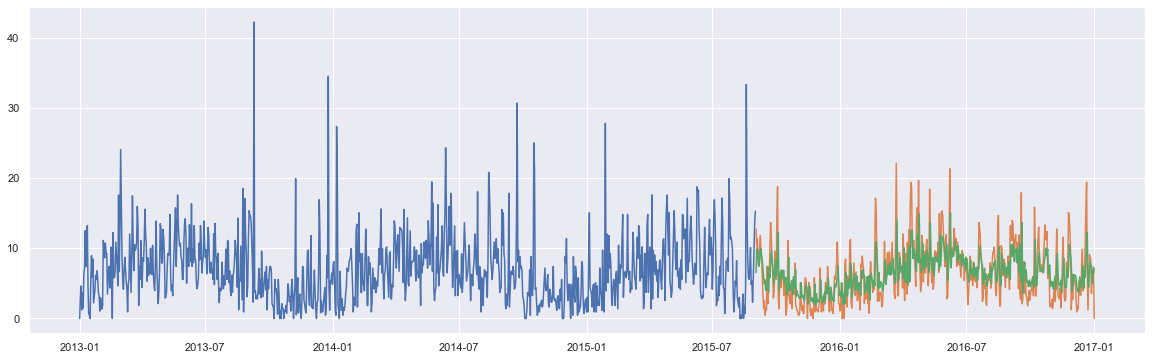

In [31]:
plt.figure(figsize=(20, 6))
plt.plot(X_train)
plt.plot(X_valid)
plt.plot(arma_valid.predict());

Testaremos três configurações para o modelo ARMA:
* $(p, q) =(1, 1)$
* $(p, q) =(2, 2)$
* $(p, q) =(3, 3)$

In [32]:
arma1 = ARMA(X_train, freq='D', order=(1, 1)).fit()
arma2 = ARMA(X_train, freq='D', order=(2, 2)).fit()
arma3 = ARMA(X_train, freq='D', order=(3, 3)).fit()

In [33]:
arma1_valid = ARMA(X_valid, freq='D', order=(1, 1)).fit(arma1.params)
arma2_valid = ARMA(X_valid, freq='D', order=(2, 2)).fit(arma2.params)
arma3_valid = ARMA(X_valid, freq='D', order=(3, 3)).fit(arma3.params)

In [34]:
print((arma1_valid.resid ** 2).mean()) 
print((arma2_valid.resid ** 2).mean()) 
print((arma3_valid.resid ** 2).mean()) 

11.453649280973245
10.884654477067507
10.825277616778614


O melhor resultado obtido foi com a configuração $(p, q) = (3, 3)$.

Abaixo, temos a vosualização dos três modelos.

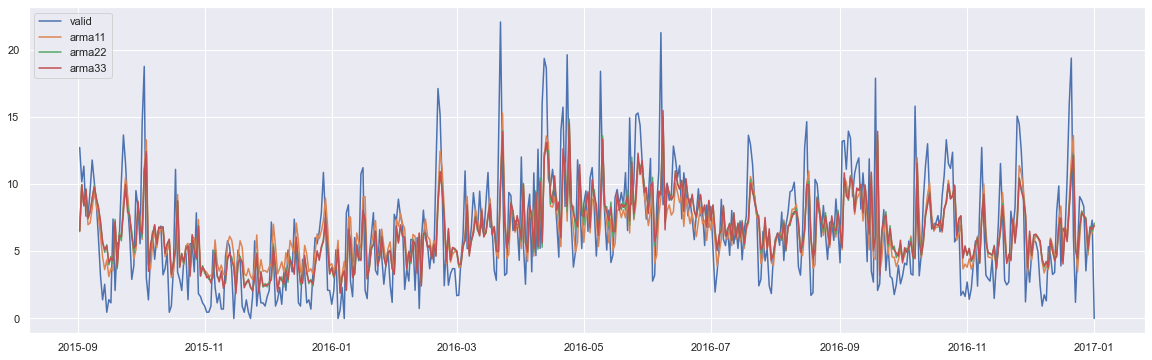

In [38]:
plt.figure(figsize=(20, 6))
plt.plot(X_valid)
plt.plot(arma1_valid.predict())
plt.plot(arma2_valid.predict())
plt.plot(arma3_valid.predict())
plt.legend(['valid', 'arma11', 'arma22', 'arma33']);

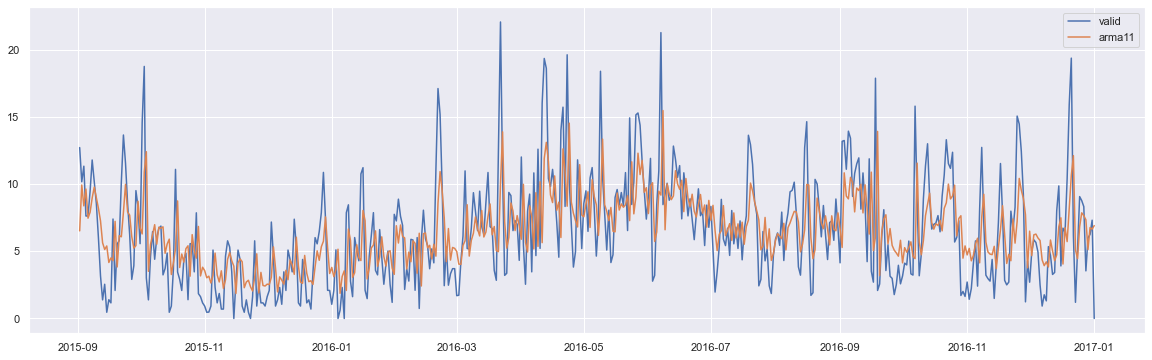

In [37]:
plt.figure(figsize=(20, 6))
plt.plot(X_valid)
plt.plot(arma3_valid.predict())
plt.legend(['valid', 'arma11', 'arma22', 'arma33']);

Para testar um conjunto de configurações, podemos utilizar um for loop do python para retornando a melhor configuração.

In [44]:
%%time

configs = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3), (4, 4)]
best = 100000

for config in configs:
    
    arma = ARMA(X_train, freq='D', order=config).fit()
    arma_test = ARMA(X_valid, freq='D', order=config).fit(arma.params)
    erro = (arma_valid.resid ** 2).mean()
    print(config, erro)
    
#     if erro < best:
#         best = erro
#         print(config, erro)

(1, 1) 10.884654477067507
(1, 2) 10.884654477067507
(2, 1) 10.884654477067507
(2, 2) 10.884654477067507
(3, 1) 10.884654477067507
(3, 2) 10.884654477067507
(3, 3) 10.884654477067507
(4, 1) 10.884654477067507
(4, 2) 10.884654477067507


C:\Users\marcu\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


(4, 3) 10.884654477067507
(4, 4) 10.884654477067507
Wall time: 10.8 s


C:\Users\marcu\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
